## Data Acquisition and Cleaning

For background on this project, please see the [README](../README.md).

**Notebooks**
- Data Acquisition & Cleaning (this notebook)
- [Exploratory Data Analysis](./02_eda.ipynb)
- [Building Recommendation Functions](./03_building_rec_function.ipynb)

**In this notebook, you'll find:**
- Dataset background info
- Data dictionary links
- Ingestion and cleaning processes
- New feature engineering

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---
#### **1. Airbnb Data**

This dataset is a compilation of the listing data for all US locations provided by [Inside Airbnb](http://insideairbnb.com/get-the-data). 

In [2]:
airbnb = pd.read_excel('../datasets/airbnbs/all_cities_airbnb.xlsx')

airbnb.head()

,place,state,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights
0,Asheville,NC,24697002,Tent Site #2 @The Baying Hound Campground,151279507,Bobby And Amanda,West Asheville,West Asheville,35.61317,-82.60451,Entire home/apt,19,1
1,Asheville,NC,25138871,Tent Site #1 @The Baying Hound Campground,151279507,Bobby And Amanda,West Asheville,West Asheville,35.61350,-82.60523,Entire home/apt,19,1
2,Asheville,NC,26634224,Tent Site #4 @The Baying Hound Campground,151279507,Bobby And Amanda,West Asheville,West Asheville,35.61314,-82.60315,Entire home/apt,19,1
3,Asheville,NC,34152268,Car Spot at The Baying Hound Campground,151279507,Bobby And Amanda,West Asheville,West Asheville,35.61148,-82.60492,Entire home/apt,19,1
4,Asheville,NC,42980053,Tent Site #6 @The Baying Hound Campground,151279507,Bobby And Amanda,West Asheville,West Asheville,35.61151,-82.60368,Entire home/apt,19,1


In [3]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278994 entries, 0 to 278993
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   place                278994 non-null  object 
 1   state                278994 non-null  object 
 2   id                   278994 non-null  int64  
 3   name                 278950 non-null  object 
 4   host_id              278994 non-null  int64  
 5   host_name            277860 non-null  object 
 6   neighbourhood_group  138467 non-null  object 
 7   neighbourhood        278994 non-null  object 
 8   latitude             278994 non-null  float64
 9   longitude            278994 non-null  float64
 10  room_type            278994 non-null  object 
 11  price                278994 non-null  int64  
 12  minimum_nights       278994 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 27.7+ MB


In [4]:
# We're seeing the most nulls in the neighborhood group column

airbnb.isnull().sum()

place                       0
state                       0
id                          0
name                       44
host_id                     0
host_name                1134
neighbourhood_group    140527
neighbourhood               0
latitude                    0
longitude                   0
room_type                   0
price                       0
minimum_nights              0
dtype: int64

In [5]:
# Fortunately, we don't have much use for the columns that have null values, so we'll be dropping these and a few others
# Neighborhood group included here because we'll only need the neighborhood column for our analysis

airbnb.drop(columns=['name', 'host_id', 'host_name', 'neighbourhood_group', 'minimum_nights'], inplace=True) 
old_shape = airbnb.shape
old_shape

(278994, 8)

In [6]:
# Checking for and removing any duplicate listings in the data
# Keeping none as I don't feel that we could accurately/fairly determine which city to leave the listing in for

airbnb.drop_duplicates(subset=['id'], keep=False, inplace=True)
print(f'Total listings dropped: {old_shape[0] - airbnb.shape[0]}')

Total listings dropped: 10151


In [7]:
airbnb['room_type'].value_counts()

Entire home/apt    202199
Private room        62695
Shared room          2765
Hotel room           1184
Name: room_type, dtype: int64

In [8]:
# For the purposes of this analysis, we are working under the assumption that all users will be looking for an entire home or apartment to rent
airbnb = (airbnb.loc[airbnb['room_type'] == 'Entire home/apt']).drop('id', axis=1).reset_index(drop=True)

# Dropping these columns as well as they aren't necessary in our analysis
airbnb.drop(columns=['latitude', 'longitude', 'room_type'], inplace = True)
airbnb

,place,state,neighbourhood,price
0,Asheville,NC,West Asheville,19
1,Asheville,NC,West Asheville,19
2,Asheville,NC,West Asheville,19
3,Asheville,NC,West Asheville,19
4,Asheville,NC,West Asheville,19
...,...,...,...,...
202194,Washington,DC,"Shaw, Logan Circle",4357
202195,Washington,DC,"Union Station, Stanton Park, Kingman Park",5000
202196,Washington,DC,"Capitol View, Marshall Heights, Benning Heights",5000
202197,Washington,DC,"Capitol Hill, Lincoln Park",5995


In [9]:
# Checking for price outliers
airbnb.describe()

,price
count,202199.000000
mean,313.913748
std,805.011127
min,1.000000
25%,125.000000
50%,188.000000
75%,300.000000
max,100000.000000


In [10]:
airbnb.sort_values('price', ascending=False)

,place,state,neighbourhood,price
50886,Fort Lauderdale,FL,Pembroke Pines,100000
58463,Jersey City,NJ,Ward E (councilmember James Solomon),99999
105944,Los Angeles,CA,Unincorporated Santa Monica Mountains,30000
114548,Maui,HI,Lahaina,26774
114547,Maui,HI,Kihei-Makena,25159
...,...,...,...,...
184825,Santa Clara,CA,Mountain View,10
114549,Nashville,TN,District 19,8
26727,Dallas,TX,District 2,5
26726,Dallas,TX,District 2,3


We can see here that there are relatively extreme outliers on both ends of the price spectrum. We do not want to remove all outliers because we want to ensure that we're still capturing the locations that are generally more expensive, but removing the upper and lower one percentile will even out our distribution slightly. 

Plotting below to visualize the effects of outlier removal.

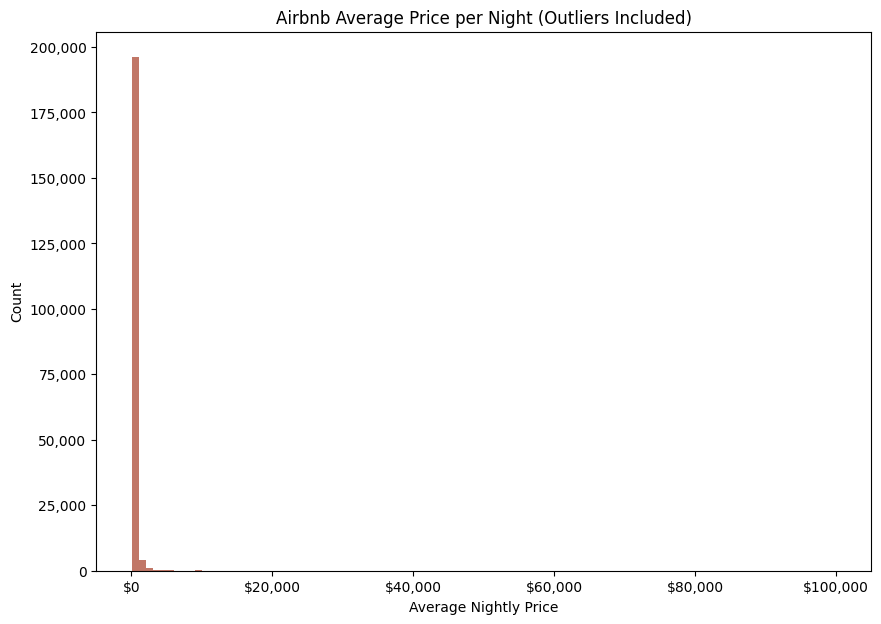

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(airbnb['price'], bins = 100, color='#C17767')
ax.set_title('Airbnb Average Price per Night (Outliers Included)')
ax.set_xlabel('Average Nightly Price')
ax.xaxis.set_major_formatter('${x:,.0f}')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_ylabel('Count');

In [12]:
upper_q = airbnb['price'].quantile(0.99)
lower_q = airbnb['price'].quantile(0.01)

print('Upper price boundary:', ('${:,.2f}').format(upper_q))
print('Lower price boundary:', ('${:,.2f}').format(lower_q))

Upper price boundary: $2,099.00
Lower price boundary: $55.00


In [13]:
airbnb = airbnb[(airbnb['price'] < upper_q) & (airbnb['price'] > lower_q)]

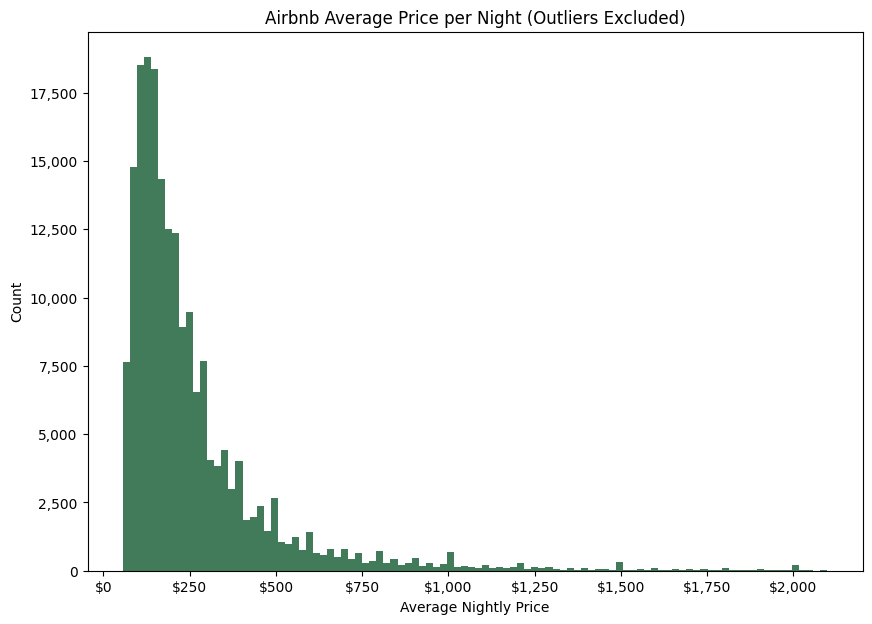

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(airbnb['price'], bins = 100, color='#417B5A')
ax.set_title('Airbnb Average Price per Night (Outliers Excluded)')
ax.set_xlabel('Average Nightly Price')
ax.xaxis.set_major_formatter('${x:,.0f}')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.set_ylabel('Count');

While definitely still skewed, the second plot looks to capture the true price distribution of the Airbnb listings. We're ready to export!

*Note: We will be adding a 'monthly average cost' column to this dataset, but because this value will be estimated (discounts for 30+ day bookings vary by host) we are going to keep as is for now and perform EDA on the known average nightly rate.*

In [15]:
airbnb.to_csv('../datasets/cleaned_data/airbnb_cleaned.csv', index=False)

Airbnb data dictionary can be found [here](../datasets/airbnbs/airbnb_data_dict.md).

---
#### **2. Restaurant Data**

The [Measuring McCities](https://github.com/friendlycities-gatech/chainness) dataset maps 800,000 restaurants across the continental United States and indicates whether the restaurant is a chain or not.

*Note: I have trimmed the data down to include only restaurants located in the noted Airbnb cities.*

In [16]:
food = pd.read_excel('../datasets/things_to_do/all_cities_food.xlsx')

food.head()

,RestaurantName,Cuisine,City,State,CNTY_GEOID,CNTY_NAME,UA_NAME,MSA_NAME,Lon,Lat,Frequency,isChain,isChain_Y_N
0,Subway,Restaurant,Los Angeles,CA,6037,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA","Los Angeles-Long Beach-Anaheim, CA",-117.99910,34.051636,24333,1,Yes
1,Subway,American Deli,San Diego,CA,6073,San Diego,"San Diego, CA","San Diego-Chula Vista-Carlsbad, CA",-117.10059,32.583042,24333,1,Yes
2,Subway,Restaurant,Los Angeles,CA,6037,Los Angeles,"Los Angeles--Long Beach--Anaheim, CA","Los Angeles-Long Beach-Anaheim, CA",-118.19185,34.110640,24333,1,Yes
3,Subway,Restaurant,San Mateo,CA,6081,San Mateo,"San Francisco--Oakland, CA","San Francisco-Oakland-Berkeley, CA",-122.29345,37.532963,24333,1,Yes
4,Subway,Restaurant,Los Angeles,CA,6037,Los Angeles,"Santa Clarita, CA","Los Angeles-Long Beach-Anaheim, CA",-118.62151,34.495663,24333,1,Yes


In [17]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154866 entries, 0 to 154865
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   RestaurantName  154866 non-null  object 
 1   Cuisine         154863 non-null  object 
 2   City            154866 non-null  object 
 3   State           154866 non-null  object 
 4   CNTY_GEOID      154866 non-null  int64  
 5   CNTY_NAME       154866 non-null  object 
 6   UA_NAME         152713 non-null  object 
 7   MSA_NAME        153780 non-null  object 
 8   Lon             154866 non-null  float64
 9   Lat             154866 non-null  float64
 10  Frequency       154866 non-null  int64  
 11  isChain         154866 non-null  int64  
 12  isChain_Y_N     154866 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 15.4+ MB


In [18]:
food.isnull().sum()

RestaurantName       0
Cuisine              3
City                 0
State                0
CNTY_GEOID           0
CNTY_NAME            0
UA_NAME           2153
MSA_NAME          1086
Lon                  0
Lat                  0
Frequency            0
isChain              0
isChain_Y_N          0
dtype: int64

In [19]:
# I plan on keeping the cuisine column for now, so I'm looking at the rows where this column is null to see if I can either impute or delete the rows
food[food['Cuisine'].isnull()]

,RestaurantName,Cuisine,City,State,CNTY_GEOID,CNTY_NAME,UA_NAME,MSA_NAME,Lon,Lat,Frequency,isChain,isChain_Y_N
82150,Modern Underground,NaN,Boston,MA,25025,Suffolk,"Boston, MA--NH--RI","Boston-Cambridge-Newton, MA-NH",-71.05467,42.363300,1,0,No
95697,Beach Club,NaN,Las Vegas,NV,32003,Clark,"Las Vegas--Henderson, NV","Las Vegas-Henderson-Paradise, NV",-115.17073,36.116510,3,0,No
134189,Dalts American Grill,NaN,Nashville,TN,47037,Davidson,"Nashville-Davidson, TN","Nashville-Davidson--Murfreesboro--Franklin, TN",-86.85211,36.129276,1,0,No


In [20]:
# I think the above three can be deleted without much effect on the dataset
food = food[food['Cuisine'].notna()].reset_index(drop=True)

# I'm going to be removing the two other columns that have null values as the City, State, and County Name columns are sufficient
food.drop(columns = ['UA_NAME', 'MSA_NAME', 'CNTY_GEOID', 'CNTY_NAME', 'Lat', 'Lon'], inplace=True)

# Renaming the remaining columns
food.columns = [col.lower() for col in food.columns]

In [21]:
food.to_csv('../datasets/cleaned_data/food_cleaned.csv', index=False)

food

,restaurantname,cuisine,city,state,frequency,ischain,ischain_y_n
0,Subway,Restaurant,Los Angeles,CA,24333,1,Yes
1,Subway,American Deli,San Diego,CA,24333,1,Yes
2,Subway,Restaurant,Los Angeles,CA,24333,1,Yes
3,Subway,Restaurant,San Mateo,CA,24333,1,Yes
4,Subway,Restaurant,Los Angeles,CA,24333,1,Yes
...,...,...,...,...,...,...,...
154858,Zolas Cafe,Cafe,Seattle,WA,1,0,No
154859,Zouave Restaurant,Italian Mediterranean European,Seattle,WA,1,0,No
154860,Zulus Board Game Cafe,Pub,Seattle,WA,1,0,No
154861,Zushi Sushi,Japanese Sushi Seafood Asian,Seattle,WA,1,0,No


Chain restaurant data dictionary can be found [here](../datasets/things_to_do/chain_rest_data_dict.md).

---
#### **3. Cost of Living Data**

This dataset comes from a compilation of data surrounding cost of living and population demographics, pulled from [BestPlaces.net](https://www.bestplaces.net/).

In [22]:
coli = pd.read_excel('../datasets/cost_of_living/all_cities_cost_of_living_index.xlsx')

coli.head()

,NAME,COST OF LIVING,Grocery,Health,Housing,Median Home Cost,Utilities,Transportation,Miscellaneous,Population,Median Age,Summer Comfort Index,Winter Comfort Index,Perc Growth Since 2020,Political Left Lean,Political Right Lean
0,Asheville,105.7,103.1,122.9,121.6,354700,96.7,82.8,111.2,92852,38.6,8.5,6.0,0.090,0.597,0.386
1,Austin,129.4,96.7,101.6,189.0,551200,99.1,109.9,105.9,995484,32.7,3.7,7.9,0.200,0.714,0.264
2,Boston,153.4,111.4,89.7,228.7,667000,116.8,131.8,157.9,691531,32.0,9.1,4.9,0.110,0.806,0.175
3,Cambridge,173.7,115.5,89.2,321.4,937500,117.8,95.7,176.7,119192,30.4,9.2,4.8,0.071,0.715,0.263
4,Chicago,107.4,97.2,88.0,99.8,291200,92.8,138.5,139.8,2677643,34.1,9.0,4.7,0.007,0.742,0.240


In [23]:
coli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NAME                    33 non-null     object 
 1   COST OF LIVING          33 non-null     float64
 2   Grocery                 33 non-null     float64
 3   Health                  33 non-null     float64
 4   Housing                 33 non-null     float64
 5   Median Home Cost        33 non-null     int64  
 6   Utilities               33 non-null     float64
 7     Transportation        33 non-null     float64
 8     Miscellaneous         33 non-null     float64
 9   Population              33 non-null     int64  
 10  Median Age              33 non-null     float64
 11  Summer Comfort Index    33 non-null     float64
 12  Winter Comfort Index    33 non-null     float64
 13  Perc Growth Since 2020  33 non-null     float64
 14  Political Left Lean     33 non-null     floa

In [24]:
# No nulls so it looks like we are good to save and export this dataset
coli.isnull().sum()

NAME                      0
COST OF LIVING            0
Grocery                   0
Health                    0
Housing                   0
Median Home Cost          0
Utilities                 0
  Transportation          0
  Miscellaneous           0
Population                0
Median Age                0
Summer Comfort Index      0
Winter Comfort Index      0
Perc Growth Since 2020    0
Political Left Lean       0
Political Right Lean      0
dtype: int64

In [25]:
# Reformatting column names
coli_cols = [(col.lower()).strip().replace(' ', '_') for col in coli.columns]
coli_cols[2:9] = [col + '_cost_idx' for col in coli_cols[2:9]]
coli.columns = coli_cols

# Adding state column
coli.insert(loc=1, column = 'state', value=[airbnb[airbnb['place'] == place]['state'].unique()[0] for place in coli['name']])

coli.head()

,name,state,cost_of_living,grocery_cost_idx,health_cost_idx,housing_cost_idx,median_home_cost_cost_idx,utilities_cost_idx,transportation_cost_idx,miscellaneous_cost_idx,population,median_age,summer_comfort_index,winter_comfort_index,perc_growth_since_2020,political_left_lean,political_right_lean
0,Asheville,NC,105.7,103.1,122.9,121.6,354700,96.7,82.8,111.2,92852,38.6,8.5,6.0,0.090,0.597,0.386
1,Austin,TX,129.4,96.7,101.6,189.0,551200,99.1,109.9,105.9,995484,32.7,3.7,7.9,0.200,0.714,0.264
2,Boston,MA,153.4,111.4,89.7,228.7,667000,116.8,131.8,157.9,691531,32.0,9.1,4.9,0.110,0.806,0.175
3,Cambridge,MA,173.7,115.5,89.2,321.4,937500,117.8,95.7,176.7,119192,30.4,9.2,4.8,0.071,0.715,0.263
4,Chicago,IL,107.4,97.2,88.0,99.8,291200,92.8,138.5,139.8,2677643,34.1,9.0,4.7,0.007,0.742,0.240


In [26]:
# Dropping columns that are not relevant to our analysis
coli.drop(columns=['health_cost_idx', 'housing_cost_idx', 'median_home_cost_cost_idx', 'utilities_cost_idx'], inplace=True)

In [27]:
coli.to_csv('../datasets/cleaned_data/coli_cleaned.csv', index=False)

Cost of living data dictionary can be found [here](../datasets/cost_of_living/cost_of_living_data_dict.md).

---
#### **4. Weather Data**

These next two datasets are smaller summaries of average temperature and rainfall for each location, courtesy of the [National Centers for Environmental Information](https://www.ncei.noaa.gov/).

In [28]:
temp = pd.read_excel('../datasets/weather/monthly_avg_temp.xlsx')

temp.head()

,Location ID,Place,State,Jan,Feb,March,April,May,June,July,Aug,Sept,Oct,Nov,Dec
0,NC-021,Asheville,NC,36.6,37.6,48.8,51.8,59.4,68.1,71.0,71.5,64.5,58.7,42.8,46.3
1,TX-453,Austin,TX,51.4,46.5,62.6,66.7,73.0,81.2,82.0,83.8,80.2,71.8,59.1,62.3
2,MA-025,Boston,MA,31.2,30.1,40.9,49.0,59.2,71.7,70.4,74.6,66.9,57.9,43.2,38.0
3,MA-017,Cambridge,MA,29.6,27.5,39.4,48.8,59.3,71.1,70.0,73.8,65.7,56.5,41.4,36.2
4,IL-031,Chicago,IL,28.4,18.9,43.1,50.6,58.8,72.8,73.4,75.6,68.8,59.1,39.4,37.1


In [29]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Location ID  33 non-null     object 
 1   Place        33 non-null     object 
 2   State        33 non-null     object 
 3   Jan          33 non-null     float64
 4   Feb          33 non-null     float64
 5   March        33 non-null     float64
 6   April        33 non-null     float64
 7   May          33 non-null     float64
 8   June         33 non-null     float64
 9   July         33 non-null     float64
 10  Aug          33 non-null     float64
 11  Sept         33 non-null     float64
 12  Oct          33 non-null     float64
 13  Nov          33 non-null     float64
 14  Dec          33 non-null     float64
dtypes: float64(12), object(3)
memory usage: 4.0+ KB


In [30]:
temp.isnull().sum()

Location ID    0
Place          0
State          0
Jan            0
Feb            0
March          0
April          0
May            0
June           0
July           0
Aug            0
Sept           0
Oct            0
Nov            0
Dec            0
dtype: int64

In [31]:
rain = pd.read_excel('../datasets/weather/monthly_avg_precipitation.xlsx')

rain.head()

,Location ID,Place,State,Jan Mean,Feb Mean,March Mean,April Mean,May Mean,June Mean,July Mean,August Mean,September Mean,October Mean,November Mean,December Mean
0,NC-021,Asheville,NC,3.75,3.69,4.69,3.76,4.03,4.37,4.88,4.89,3.63,3.53,3.11,3.69
1,TX-453,Austin,TX,1.99,2.32,2.15,3.28,4.34,3.22,2.09,1.85,3.18,3.38,2.52,2.42
2,MA-025,Boston,MA,3.92,3.50,4.03,3.97,3.37,3.36,3.41,3.62,3.63,3.44,4.04,4.01
3,MA-017,Cambridge,MA,3.60,3.26,3.90,3.82,3.40,3.51,3.55,3.51,3.66,3.37,4.00,3.85
4,IL-031,Chicago,IL,1.78,1.46,2.56,3.38,3.73,3.97,3.49,3.47,3.42,2.70,2.44,2.04


In [32]:
rain.isnull().sum()

Location ID       0
Place             0
State             0
Jan Mean          0
Feb Mean          0
March Mean        0
April Mean        0
May Mean          0
June Mean         0
July Mean         0
August Mean       0
September Mean    0
October Mean      0
November Mean     0
December Mean     0
dtype: int64

These datasets are free from nulls, so I'm now going to reformat and also combine into a single dataframe for potential future use.

In [33]:
# Column name updates for clarity and ID drop

# Temp data
temp_cols = [col.lower() for col in temp.columns]
temp_cols[3:] = [col[:3] + '_avg_temp' for col in temp_cols[3:]]
temp.columns = temp_cols

# Rain data
rain_cols =[col.lower() for col in rain.columns]
rain_cols[3:] = [col[:3] + '_avg_rain' for col in rain_cols[3:]]
rain.columns = rain_cols

# Dropping location_id column from both dfs
for cols in [temp, rain]:
    cols.drop(cols.columns[0], axis=1, inplace=True)

In [34]:
# Verifying and saving to csv format 
temp.to_csv('../datasets/cleaned_data/temp_cleaned.csv', index=False)
temp.head()

,place,state,jan_avg_temp,feb_avg_temp,mar_avg_temp,apr_avg_temp,may_avg_temp,jun_avg_temp,jul_avg_temp,aug_avg_temp,sep_avg_temp,oct_avg_temp,nov_avg_temp,dec_avg_temp
0,Asheville,NC,36.6,37.6,48.8,51.8,59.4,68.1,71.0,71.5,64.5,58.7,42.8,46.3
1,Austin,TX,51.4,46.5,62.6,66.7,73.0,81.2,82.0,83.8,80.2,71.8,59.1,62.3
2,Boston,MA,31.2,30.1,40.9,49.0,59.2,71.7,70.4,74.6,66.9,57.9,43.2,38.0
3,Cambridge,MA,29.6,27.5,39.4,48.8,59.3,71.1,70.0,73.8,65.7,56.5,41.4,36.2
4,Chicago,IL,28.4,18.9,43.1,50.6,58.8,72.8,73.4,75.6,68.8,59.1,39.4,37.1


In [35]:
# Verifying and saving to csv format 
rain.to_csv('../datasets/cleaned_data/rain_cleaned.csv', index=False)
rain.head()

,place,state,jan_avg_rain,feb_avg_rain,mar_avg_rain,apr_avg_rain,may_avg_rain,jun_avg_rain,jul_avg_rain,aug_avg_rain,sep_avg_rain,oct_avg_rain,nov_avg_rain,dec_avg_rain
0,Asheville,NC,3.75,3.69,4.69,3.76,4.03,4.37,4.88,4.89,3.63,3.53,3.11,3.69
1,Austin,TX,1.99,2.32,2.15,3.28,4.34,3.22,2.09,1.85,3.18,3.38,2.52,2.42
2,Boston,MA,3.92,3.50,4.03,3.97,3.37,3.36,3.41,3.62,3.63,3.44,4.04,4.01
3,Cambridge,MA,3.60,3.26,3.90,3.82,3.40,3.51,3.55,3.51,3.66,3.37,4.00,3.85
4,Chicago,IL,1.78,1.46,2.56,3.38,3.73,3.97,3.49,3.47,3.42,2.70,2.44,2.04


In [36]:
# Combined df

# Merging dfs
weather = pd.merge(temp, rain, how='outer', on=['place'], suffixes=(None, 'left'))
weather.drop(columns='stateleft', inplace=True)

# Adding temp seasonal average columns to use in EDA
weather['winter_avg_temp'] = (weather['dec_avg_temp'] + weather['jan_avg_temp'] + weather['feb_avg_temp'])/3
weather['spring_avg_temp'] = (weather['mar_avg_temp'] + weather['apr_avg_temp'] + weather['may_avg_temp'])/3
weather['summer_avg_temp'] = (weather['jun_avg_temp'] + weather['jul_avg_temp'] + weather['aug_avg_temp'])/3
weather['autumn_avg_temp'] = (weather['sep_avg_temp'] + weather['oct_avg_temp'] + weather['nov_avg_temp'])/3

# Adding rain seasonal average columns to use in EDA
weather['winter_avg_rain'] = (weather['dec_avg_rain'] + weather['jan_avg_rain'] + weather['feb_avg_rain'])/3
weather['spring_avg_rain'] = (weather['mar_avg_rain'] + weather['apr_avg_rain'] + weather['may_avg_rain'])/3
weather['summer_avg_rain'] = (weather['jun_avg_rain'] + weather['jul_avg_rain'] + weather['aug_avg_rain'])/3
weather['autumn_avg_rain'] = (weather['sep_avg_rain'] + weather['oct_avg_rain'] + weather['nov_avg_rain'])/3

# Saving and verifying
weather.to_csv('../datasets/cleaned_data/weather_combined.csv', index=False)
weather.head()

,place,state,jan_avg_temp,feb_avg_temp,mar_avg_temp,apr_avg_temp,may_avg_temp,jun_avg_temp,jul_avg_temp,aug_avg_temp,...,nov_avg_rain,dec_avg_rain,winter_avg_temp,spring_avg_temp,summer_avg_temp,autumn_avg_temp,winter_avg_rain,spring_avg_rain,summer_avg_rain,autumn_avg_rain
0,Asheville,NC,36.6,37.6,48.8,51.8,59.4,68.1,71.0,71.5,...,3.11,3.69,40.166667,53.333333,70.200000,55.333333,3.710000,4.160000,4.713333,3.423333
1,Austin,TX,51.4,46.5,62.6,66.7,73.0,81.2,82.0,83.8,...,2.52,2.42,53.400000,67.433333,82.333333,70.366667,2.243333,3.256667,2.386667,3.026667
2,Boston,MA,31.2,30.1,40.9,49.0,59.2,71.7,70.4,74.6,...,4.04,4.01,33.100000,49.700000,72.233333,56.000000,3.810000,3.790000,3.463333,3.703333
3,Cambridge,MA,29.6,27.5,39.4,48.8,59.3,71.1,70.0,73.8,...,4.00,3.85,31.100000,49.166667,71.633333,54.533333,3.570000,3.706667,3.523333,3.676667
4,Chicago,IL,28.4,18.9,43.1,50.6,58.8,72.8,73.4,75.6,...,2.44,2.04,28.133333,50.833333,73.933333,55.766667,1.760000,3.223333,3.643333,2.853333


Aggregated weather data dictionary can be found [here](../datasets/weather/weather_data_dict.md).

---
#### **5. Walkability Data**

The walkability dataset comes from the [US Environmental Protection Agency](https://www.epa.gov/smartgrowth/smart-location-mapping#walkability) and includes an extensive amount of data on population demographics, commute time, auto/transit scores, and walkability by census block in each state. I'll be trimming down the columns to keep only the information necessary for this project.

*Note: Many column names are nondescript - the columns that are kept will be renamed to provide more information.*


In [37]:
walk = pd.read_excel('../datasets/walkability/county_walkability.xlsx')

walk.head()

,OBJECTID,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CBSA,CBSA_Name,CITY,COUNTY,...,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,NatWalkInd
0,31471,60371872002,6,37,187200,2,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,Los Angeles County,...,179176,0.000190,0.687220,0.000175,0.743993,0.000201,0.309765,0.000133,0.178820,13.333333
1,31472,60371873001,6,37,187300,1,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,Los Angeles County,...,215915,0.000210,0.759693,0.000195,0.826888,0.000231,0.355790,0.000160,0.215486,17.000000
2,31473,60371873002,6,37,187300,2,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,Los Angeles County,...,203668,0.000201,0.727850,0.000186,0.787636,0.000223,0.343838,0.000151,0.203264,13.833333
3,31477,60375437024,6,37,543702,4,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,Los Angeles County,...,117860,0.000142,0.513994,0.000149,0.633264,0.000071,0.109811,0.000087,0.117626,14.166667
4,31478,60375437025,6,37,543702,5,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,Los Angeles County,...,112039,0.000141,0.512053,0.000148,0.630382,0.000065,0.100529,0.000083,0.111817,17.166667


In [38]:
walk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39776 entries, 0 to 39775
Data columns (total 46 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OBJECTID      39776 non-null  int64  
 1   GEOID20       39776 non-null  int64  
 2   STATEFP       39776 non-null  int64  
 3   COUNTYFP      39776 non-null  int64  
 4   TRACTCE       39776 non-null  int64  
 5   BLKGRPCE      39776 non-null  int64  
 6   CBSA          39776 non-null  int64  
 7   CBSA_Name     39776 non-null  object 
 8   CITY          39776 non-null  object 
 9   COUNTY        39776 non-null  object 
 10  STATE         39776 non-null  object 
 11  CBSA_POP      39776 non-null  int64  
 12  CBSA_EMP      39776 non-null  int64  
 13  CBSA_WRK      39776 non-null  int64  
 14  TotPop        39776 non-null  int64  
 15  CountHU       39776 non-null  int64  
 16  HH            39776 non-null  int64  
 17  P_WrkAge      39776 non-null  float64
 18  AutoOwn0      39776 non-nu

In [39]:
walk.columns

Index(['OBJECTID', 'GEOID20', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE',
       'CBSA', 'CBSA_Name', 'CITY', 'COUNTY', 'STATE', 'CBSA_POP', 'CBSA_EMP',
       'CBSA_WRK', 'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0',
       'Pct_AO0', 'AutoOwn1', 'Pct_AO1', 'AutoOwn2p', 'Pct_AO2p', 'Workers',
       'R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'R_PCTLOWWAGE', 'TotEmp',
       'D4C', 'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR', 'D5CRI',
       'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI', 'NatWalkInd'],
      dtype='object')

In [40]:
walk = walk[['CITY', 'STATE', 'Pct_AO0', 'D5CEI', 'D5DEI', 'NatWalkInd']]

# Verifying the trimmed df
walk.head()

,CITY,STATE,Pct_AO0,D5CEI,D5DEI,NatWalkInd
0,Los Angeles,CA,0.033097,0.743993,0.178820,13.333333
1,Los Angeles,CA,0.019506,0.826888,0.215486,17.000000
2,Los Angeles,CA,0.000000,0.787636,0.203264,13.833333
3,Los Angeles,CA,0.023077,0.633264,0.117626,14.166667
4,Los Angeles,CA,0.000000,0.630382,0.111817,17.166667


In [41]:
# Renaming columns
walk.columns = ['place', 'state', 'pct_no_vehicle', 'auto_accss_idx', 'transit_accss_idx', 'walkability_idx']

# Adding a column to indicate the percent of homes with one or more vehicle in the census block
walk['pct_one_or_more_vehicles'] = 1 - walk['pct_no_vehicle']

In [42]:
walk.isnull().sum()

place                       0
state                       0
pct_no_vehicle              0
auto_accss_idx              0
transit_accss_idx           0
walkability_idx             0
pct_one_or_more_vehicles    0
dtype: int64

In [43]:
walk.describe()

,pct_no_vehicle,auto_accss_idx,transit_accss_idx,walkability_idx,pct_one_or_more_vehicles
count,39776.000000,39776.000000,39776.000000,39776.000000,39776.000000
mean,0.168345,0.598085,-17442.276339,12.908295,0.831655
std,0.217931,0.197721,37947.809092,3.525052,0.217931
min,0.000000,0.000000,-99999.000000,1.000000,0.000000
25%,0.018961,0.472724,0.047148,11.000000,0.771429
50%,0.075042,0.614913,0.185063,13.500000,0.924958
75%,0.228571,0.751171,0.368325,15.500000,0.981039
max,1.000000,1.000000,1.000000,20.000000,1.000000


In [44]:
walk['transit_accss_idx'].value_counts()

-99999.000000    6938
 1.000000          20
 0.092344           3
 0.063871           3
 0.046576           2
                 ... 
 0.249972           1
 0.228377           1
 0.333025           1
 0.444343           1
 0.671434           1
Name: transit_accss_idx, Length: 32692, dtype: int64

In [45]:
walk[walk['transit_accss_idx'] == -99999]['place'].unique()

array(['Los Angeles', 'Santa Clara', 'San Mateo', 'Oakland', 'Santa Cruz',
       'San Francisco', 'San Diego', 'Denver', 'Fort Lauderdale', 'Kauai',
       'Maui', 'Hawaii', 'Oahu', 'New Orleans', 'Rhode Island',
       'Asheville', 'Cambridge', 'Boston', 'Las Vegas', 'Columbus',
       'Salem', 'Newark', 'Jersey City', 'New York City', 'Nashville',
       'Dallas', 'Fort Worth', 'Austin', 'Portland', 'Seattle', 'Chicago',
       'Twin Cities', 'Washington'], dtype=object)

While there are no nulls, it looks like the transit_accss_idx column has some placeholder values that are not meant to represent any real amount. From the above, we can see that this placeholder is used at least once in all cities. Before I decide how to handle these, I'm going to look at how many times -99999 occurs in each location.

My thought process here is that this is a large enough dataset that dropping those 6,938 rows should not drastically change the data. However, if this value is present in all observations of a specific location, then dropping the rows will remove said location from the entire df.

In [46]:
# Building a temporary dataframe to look at and filter based on the transit_accss_idx values
nines = pd.DataFrame(walk.groupby(['place', 'transit_accss_idx']).size())

# Sectioning the df to only include the counts of -99999 and renaming the column
nines = nines.xs(-99999, level=1).reset_index()
nines.rename(columns={0: '99999_count'}, inplace=True)

# Using list comp to pull the number of place occurrences in the walk dataset and adding these as a column
place_counts = [val for val in walk.groupby('place').size()]
nines['place_count'] = place_counts

In [47]:
nines

,place,99999_count,place_count
0,Asheville,93,154
1,Austin,194,580
2,Boston,3,646
3,Cambridge,307,1133
4,Chicago,426,3993
5,Columbus,281,887
6,Dallas,352,1669
7,Denver,8,481
8,Fort Lauderdale,173,940
9,Fort Worth,772,1177


In [48]:
# Filtering to see where the number of -99999 occurrences matches the total number of location occurrences
nines[nines['99999_count'] == nines['place_count']]

,place,99999_count,place_count
10,Hawaii,123,123
12,Kauai,56,56
15,Maui,103,103


It looks like Hawaii (the Big Island), Kauai, and Maui have missing transit data in all observations. Because I do not want to lose these locations entirely, I am going to fill all placeholder values with zeroes.  

This will likely affect the mean and median of the locations, but this seems like a better option than dropping entirely, and the aggregate amounts will be affected in proportion to how many empty values there are, which keeps the integrity of the relative measurement. 

In [49]:
walk.replace(-99999, 0, inplace=True)

walk.describe()

,pct_no_vehicle,auto_accss_idx,transit_accss_idx,walkability_idx,pct_one_or_more_vehicles
count,39776.000000,39776.000000,39776.000000,39776.000000,39776.000000
mean,0.168345,0.598085,0.228236,12.908295,0.831655
std,0.217931,0.197721,0.206805,3.525052,0.217931
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.018961,0.472724,0.047148,11.000000,0.771429
50%,0.075042,0.614913,0.185063,13.500000,0.924958
75%,0.228571,0.751171,0.368325,15.500000,0.981039
max,1.000000,1.000000,1.000000,20.000000,1.000000


Most columns are self-explanatory, but for clarity, the auto_accss_idx and transit_accss_idx columns are relative indices defined by the EPA as the 'Regional Centrality Index – Auto: CBG D5ce score relative to max CBSA D5ce score' and the 'Regional Centrality Index – Transit: CBG D5de score relative to max CBSA D5de score,' respectively. 

Essentially, these values are measurements of a census block's centrality and regional accessibility, based on the proportions of working-age people in each area who are able to get to their destinations via vehicle (theirs or someone else's) or transit.

Because we are not looking at our locations by specific block in any of the other datasets, I'm going to aggregate by each place and get the average values of each column to use as our overall metrics

In [50]:
walk = (walk.pivot_table(index = ['place', 'state'], values=['pct_no_vehicle', 'auto_accss_idx', 'transit_accss_idx', 'walkability_idx', 'pct_one_or_more_vehicles'], aggfunc='mean')).reset_index()

walk.head()

,place,state,auto_accss_idx,pct_no_vehicle,pct_one_or_more_vehicles,transit_accss_idx,walkability_idx
0,Asheville,NC,0.580614,0.053756,0.946244,0.149850,9.382035
1,Austin,TX,0.718323,0.059187,0.940813,0.286952,11.516379
2,Boston,MA,0.759096,0.301252,0.698748,0.409262,14.936791
3,Cambridge,MA,0.563985,0.102769,0.897231,0.160956,12.458517
4,Chicago,IL,0.636256,0.169022,0.830978,0.310866,13.635529


In [51]:
walk.to_csv('../datasets/cleaned_data/walkability_cleaned.csv', index=False)

Walkability data dictionary can be found [here](../datasets/walkability/walkability_data_dict.md).

---
#### **Final Notes**
- All final datasets were exported to the cleaned_datasets folder, and will be used in subsequent EDA and modeling.
- All data dictionaries can be found in their respective original dataset directories.
- The next notebook in this series is [Exploratory Data Analysis](./02_eda.ipynb).